# 4.1. OLS model

## 4.1.1. Train model

### Preprocessing module

In [24]:
import json
import logging
import numpy as np
import pandas as pd
import statsmodels.api as sm

CURRENT_YEAR = 2025
MODEL_REF_PRICE_PATH = "../data/raw/model_ref_price_full.csv"
MODEL_REF_EXTRA_PRICE_PATH = "../data/raw/model_ref_price_extra.csv"
COUNTRY_MULTIPLIER_PATH = "../data/raw/origin_country_multiplier.csv"
SCOLI_PATH = "../data/raw/input_scoli_2023.json"


def read_json_stat(file_path: str) -> pd.DataFrame:
    """
    Read a JSON-stat file as an input and return a parsed Dataframe
    """
    with open(file_path, encoding="utf-8") as input_file:
        data = json.load(input_file)

    # Extracting the dimensions and values
    dimensions = data["dataset"]["dimension"]
    values = data["dataset"]["value"]

    # Creating a list of headers for the DataFrame
    headers = [dimensions[dim]["label"] for dim in dimensions["id"]] + ["Value"]

    # Creating a list of rows for the DataFrame
    rows = []
    for i, value in enumerate(values):
        row = []
        for dim in dimensions["id"]:
            for key, index in dimensions[dim]["category"]["index"].items():
                if index == i % dimensions["size"][dimensions["id"].index(dim)]:
                    row.append(dimensions[dim]["category"]["label"][key])
        row.append(value)
        rows.append(row)

    # Creating the DataFrame
    df = pd.DataFrame(rows, columns=headers)

    return df


def transform_mileage(df_col: pd.Series) -> pd.Series:
    df = df_col.to_frame()
    df["mileage"] = df.iloc[:, 0]
    df["mileage_log"] = np.log(df["mileage"])
    return df["mileage_log"]


def transform_model(df_col: pd.Series) -> pd.Series:
    # Get reference value
    df_variants = pd.read_csv(MODEL_REF_PRICE_PATH)
    df_model_extra = pd.read_csv(MODEL_REF_EXTRA_PRICE_PATH)

    # Filter out null price
    df_variants.dropna(subset="price_min", inplace=True)

    # Get mean price
    df_variants["price_avg"] = (df_variants["price_min"] + df_variants["price_max"]) / 2

    # Get model. Resolve case with 'Air Blade'
    df_variants["model_original"] = (
        df_variants["model_name"].str.split().apply(lambda x: x[0])
    )
    df_variants["model"] = df_variants["model_original"].case_when(
        caselist=[
            (df_variants["model_name"].str.contains("Air Blade"), "Air Blade"),
            (df_variants["model_name"].str.contains("SH Mode"), "SH Mode"),
            (df_variants["model_name"].str.contains("Super Cub"), "Cub"),
            (df_variants["model_name"].str.contains("Winner X"), "Winner X"),
            (df_variants["brand_name"].eq("Vespa"), "Vespa"),
        ]
    )

    # Get average price by model
    df_model_ref_price_original = df_variants.groupby(by="model", as_index=False).agg(
        {"price_avg": "mean"}
    )
    df_model_ref_price = pd.concat([df_model_ref_price_original, df_model_extra])
    df_model_ref_price["price_avg_log"] = np.log(
        df_model_ref_price["price_avg"] * 1_000
    )

    # Join with dataframe
    df = df_col.to_frame()
    df["model"] = df.iloc[:, 0]

    output_df = df.merge(
        right=df_model_ref_price, left_on="model", right_on="model", how="left"
    )

    return output_df["price_avg_log"]


def transform_origin(df_col: pd.Series) -> pd.Series:
    # Get reference value
    df_countries = pd.read_csv(COUNTRY_MULTIPLIER_PATH)

    # Join with dataframe
    df = df_col.to_frame()
    df["origin"] = df.iloc[:, 0]
    output_df = df.merge(
        right=df_countries, left_on="origin", right_on="country_name", how="left"
    )

    # Check for nan values
    count_nan_value = int(output_df["country_multiplier"].isnull().sum())
    if count_nan_value > 0:
        logging.error(
            f"There are nan values: {output_df[output_df['country_multiplier'].isnull()]}"
        )
        raise ValueError(f"Found {count_nan_value} nan values")

    return output_df["country_multiplier"]


def transform_province(df_col: pd.Series) -> pd.Series:
    """
    Note that the input here must be picked from the input_scoli itself,
    otherwise join will introduce nan values
    """
    # Get reference value
    df_scoli = read_json_stat(file_path=SCOLI_PATH)
    df_scoli.columns = ["province", "year", "province_scoli"]

    # Join with dataframe
    df = df_col.to_frame()
    df["province"] = df.iloc[:, 0]
    output_df = df.merge(
        right=df_scoli, left_on="province", right_on="province", how="left"
    )

    # Check for nan values
    count_nan_value = int(output_df["province_scoli"].isnull().sum())
    if count_nan_value > 0:
        logging.error(
            f"There are nan values: {output_df[output_df['province_scoli'].isnull()]}"
        )
        raise ValueError(f"Found {count_nan_value} nan values")

    return output_df["province_scoli"]


def transform_reg_year(df_col: pd.Series) -> pd.Series:
    # Read column
    df = df_col.to_frame()
    df["reg_year"] = df.iloc[:, 0]
    df["age"] = CURRENT_YEAR - df["reg_year"]

    # Move age = 0 to age = 0.5 since the bike must have some age
    df["age_updated"] = df["age"].case_when(caselist=[(df["age"].eq(0), 0.5)])

    df["age_log"] = np.log(df["age_updated"])

    return df["age_log"]


def transform_prediction_input(input: dict) -> np.ndarray:
    """
    Transform inputs from user and output as the model input
    Input should have these fields:
    - mileage
    - model
    - origin
    - province
    - reg_year
    """
    df = pd.DataFrame(input)
    df["age_log"] = transform_reg_year(df_col=df["reg_year"])
    df["mileage_log"] = transform_mileage(df_col=df["mileage"])
    df["origin_multiplier"] = transform_origin(df_col=df["origin"])
    df["model_ref_price_log"] = transform_model(df_col=df["model"])
    df["province_scoli"] = transform_province(df_col=df["province"])

    X = sm.add_constant(
        data=df[
            [
                "age_log",
                "mileage_log",
                "origin_multiplier",
                "model_ref_price_log",
                # "province_scoli",
            ]
        ],
        has_constant="add",
    )

    return X


def mean_absolute_percentage_error(y_true, y_pred, axis: int = None):
    """
    Ref:
    - https://stackoverflow.com/questions/55996319/my-mape-mean-absolute-percentage-error-function-returns-a-number-over-100-when
    - https://www.statsmodels.org/dev/_modules/statsmodels/tools/eval_measures.html#meanabs

    Returns: percentage without multiplying with 100
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true), axis=axis)

### Prepare data for model

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import meanabs, mse, rmse

INPUT_FILE_PATH = "../data/raw/chotot_data.csv"
ORIGIN_MAPPING = {
    "Thái Lan": ["thái", "thai lan", "xe thái"],
    "Nhật Bản": ["nhật", "nhat ban", "xe nhật"],
    "Indonesia": ["indonesia", "xe indo"],
    "Ý": ["ý", "italia"],
    "Mỹ": ["mỹ", "america", "xe mỹ"],
    "Trung Quốc": ["trung", "xe tq", "xe trung quốc", "trung quốc"],
    "Ấn Độ": ["ấn", "xe ấn", "an do"],
    "Hàn Quốc": ["hàn", "xe hàn", "han quoc"],
    "Đức": ["đức", "xe đức", "duc"],
    "Đài Loan": ["đài", "xe đài", "dai loan"],
}

# Config pandas
pd.options.mode.copy_on_write = True

df = pd.read_csv(INPUT_FILE_PATH)

# Clean columns
df["price_clean"] = pd.to_numeric(df["price"].str.replace("đ", "").str.replace(".", ""))
df["province"] = df["location"].str.split(", ").apply(lambda x: x[-1])
df["province_clean"] = df["province"].case_when(
    caselist=[
        (df["province"].eq("Tp Hồ Chí Minh"), "TP. Hồ Chí Minh"),
        (df["province"].eq("Bà Rịa - Vũng Tàu"), "Bà Rịa-Vũng Tàu"),
        (df["province"].eq("Thừa Thiên Huế"), "Thừa Thiên - Huế"),
        (df["province"].eq("Thanh Hóa"), "Thanh Hoá"),
        (df["province"].eq("Khánh Hòa"), "Khánh Hoà"),
        (df["province"].eq("Hòa Bình"), "Hoà Bình"),
    ]
)
df["reg_year_clean"] = pd.to_numeric(
    df["reg_year"].case_when(caselist=[(df["reg_year"].eq("trước năm 1980"), 1980)])
)


# Update origin from description and title
def update_origin(row):
    if row["origin"].lower() in ["đang cập nhật", "nước khác"]:
        text = f"{row['description']} {row['title']}".lower().strip()
        for country, keywords in ORIGIN_MAPPING.items():
            if any(re.search(rf"\b{keyword}\b", text) for keyword in keywords):
                return country
        return "Việt Nam"
    else:
        return row["origin"]


df["origin_updated"] = df.apply(update_origin, axis=1)

# Reduce scale of price and transform to log
df["price_clean"] = df["price_clean"] / 1_000
df["price_log"] = np.log(df["price_clean"])


# Transform columns into suitable predictors
# Note that this operation should be done before filter, since
# filter will remove some indexes. Some transforms use merge, which
# reset index, making the output becomes difficult to understand.
df["mileage_log"] = transform_mileage(df["mileage"])
df["model_ref_price_log"] = transform_model(df["model"])
df["origin_multiplier"] = transform_origin(df["origin_updated"])
df["province_scoli"] = transform_province(df["province_clean"])
df["age_log"] = transform_reg_year(df["reg_year_clean"])


# Filter

## Remove vague models
df_filter = df[~df["model"].isin(["Dòng khác", "dòng khác"])]

## Price should be at least 1M. Look at offers at 600M maximum
df_filter = df_filter[
    df_filter["price_clean"].between(1_000, 600_000, inclusive="neither")
]

## Get rows with reference price only
df_filter = df_filter[df_filter["model_ref_price_log"].notnull()]


# Models with over 30 offers only
df_model_count = df_filter.groupby("model").agg(counts=("model", "count")).reset_index()
df_model_over_n = df_model_count[df_model_count["counts"] >= 30]
df_filter = df_filter[df_filter["model"].isin(df_model_over_n["model"])]

## Remove outliers, unreasonable price. These are either
## only the bike component, or are actually another model
df_filter = df_filter[
    ~((df_filter["model"] == "SH") & (df_filter["price_clean"] < 3_000))
]

# df_filter = df_filter[~df_filter["model"].isin(["Vespa", "Cub", "R", "Dream"])]


## Try keeping records with sensible mileage
df_filter = df_filter[df_filter["mileage"].between(500, 900_000)]

# Linear regression models
Y = df_filter["price_log"]
X1 = sm.add_constant(
    data=df_filter[
        [
            "age_log",
            "mileage_log",
            "origin_multiplier",
            "model_ref_price_log",
            "province_scoli",
        ]
    ]
)

# # Split train test data
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X, Y, test_size=0.20, random_state=42
# )

d:\Thac si\02_Phat trien phan mem nang cao\khdl2024-ptpm-gia-xe-cu\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Thac si\02_Phat trien phan mem nang cao\khdl2024-ptpm-gia-xe-cu\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Create model

In [26]:
model_1 = sm.OLS(Y, X1).fit()
print(f"{model_1.summary()=}")

model_1.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     1394.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:02:21   Log-Likelihood:                -11078.
No. Observations:               10492   AIC:                         2.217e+04
Df Residuals:                   10486   BIC:                         2.221e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

## 4.1.2. Improve model accuracy

### Analyze influential outliers

#### Top influential outliers

In [27]:
# Diagnose influential points
# Ref: https://towardsdatascience.com/linear-regression-models-and-influential-points-4ee844adac6d/
df_influence = model_1.get_influence().summary_frame()
# Join on index
df_with_influence = df_filter.join(other=df_influence)

# Number of observations
n = len(df_influence)
# Predictors
k = 6
cutoff_leverage = ((2 * k) + 2) / n
cutoff_cooks: float = df_influence["cooks_d"].mean() * 3

# Values with high hat values / Cook distance
df_high_leverage = df_with_influence[df_with_influence["hat_diag"] >= cutoff_leverage]
df_high_cooks_d = df_with_influence[df_with_influence["cooks_d"] >= cutoff_cooks]

# High hat values / Cook distance count group by model
df_high_leverage.groupby("model")["hat_diag"].count()
df_model_high_leverage_count = (
    df_high_leverage.groupby("model")["hat_diag"]
    .count()
    .sort_values(ascending=False)
    .reset_index()
)

df_high_cooks_d.groupby("model")["cooks_d"].count()
df_model_high_cook_count = (
    df_high_cooks_d.groupby("model")["cooks_d"]
    .count()
    .sort_values(ascending=False)
    .reset_index()
)

# Count by model, joined with hat value and cook distance count
df_model_count = (
    df_filter.groupby("model")["price_clean"]
    .agg(counts="count")
    .sort_values(by="counts", ascending=False)
    .reset_index()
)
df_count_join = df_model_count.merge(
    right=df_model_high_leverage_count, left_on="model", right_on="model", how="left"
).merge(right=df_model_high_cook_count, left_on="model", right_on="model", how="left")
df_count_join.fillna(0, inplace=True)

# Calculate influential observation percentage
df_count_join["high_leverage_pct"] = df_count_join["hat_diag"] / df_count_join["counts"]
df_count_join["high_cook_pct"] = df_count_join["cooks_d"] / df_count_join["counts"]
df_count_join.sort_values("high_leverage_pct", ascending=False).head(10)

,model,counts,hat_diag,cooks_d,high_leverage_pct,high_cook_pct
23,R,48,48.0,48.0,1.000000,1.000000
6,Dream,497,52.0,210.0,0.104628,0.422535
13,Cub,308,30.0,76.0,0.097403,0.246753
10,Vespa,367,23.0,135.0,0.062670,0.367847
15,SH Mode,182,7.0,0.0,0.038462,0.000000
21,Blade,90,3.0,0.0,0.033333,0.000000
0,Wave,1620,54.0,90.0,0.033333,0.055556
25,Elegant,31,1.0,0.0,0.032258,0.000000
2,SH,1079,33.0,173.0,0.030584,0.160334
4,Future,526,16.0,34.0,0.030418,0.064639


#### Try removing outliers

In [28]:
df_filter_2 = df_filter[~df_filter["model"].isin(["Vespa", "Cub", "R", "Dream"])]
# Recreate Y to have same index, or will output error
Y2 = df_filter_2["price_log"]
X2 = sm.add_constant(
    data=df_filter_2[
        [
            "age_log",
            "mileage_log",
            "origin_multiplier",
            "model_ref_price_log",
            "province_scoli",
        ]
    ]
)
model_2 = sm.OLS(Y2, X2).fit()
print(f"{model_2.summary()=}")

model_2.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     2499.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:03:07   Log-Likelihood:                -8142.4
No. Observations:                9272   AIC:                         1.630e+04
Df Residuals:                    9266   BIC:                         1.634e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

#### Analyze outliers

array([[<Axes: title={'center': 'price_clean'}>]], dtype=object)

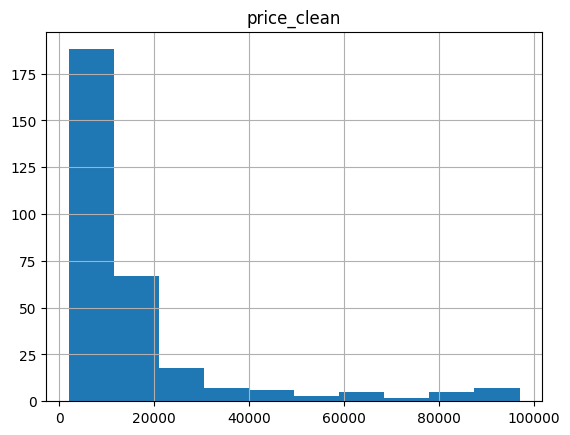

In [29]:
# Cub price distribution
df_filter[df_filter["model"] == "Cub"][["price_clean"]].hist()

# There seems to be 2 variations
# - Popular variation with price around 15 mil
# - Current variation in production around 88 mil
# > Need variation detection

In [30]:
# Vespa
# See model_ref_price_full.csv
# Wild difference in variation price

### Remove weak predictors

In [31]:
X3 = sm.add_constant(
    data=df_filter_2[
        [
            "age_log",
            "mileage_log",
            "origin_multiplier",
            "model_ref_price_log",
            # "province_scoli",
        ]
    ]
)
model_3 = sm.OLS(Y2, X3).fit()
print(f"{model_3.summary()=}")

model_3.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     3123.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:03:07   Log-Likelihood:                -8142.7
No. Observations:                9272   AIC:                         1.630e+04
Df Residuals:                    9267   BIC:                         1.633e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------